In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import corner

In [2]:
class Proposal:
    def propose(self, chain):
        pass

    @property
    def ndim(self) -> int:
        pass

class Sampler:
    def __init__(self, log_prob, ndim, proposals, proposal_weights):
        self.log_prob = log_prob

        assert all(prop.ndim == ndim for prop in proposals)
        
        self.proposals = proposals
        self.proposal_weights = np.array(proposal_weights) / np.sum(proposal_weights)
        self.ndim = ndim

        self.chain = []
        self.log_probs = []
        self.num_accepted = 0
    
    def take_step(self, proposal):
        x_now = self.chain[-1]
        log_prob_now = self.log_probs[-1]
        
        x_new, log_hastings_ratio = proposal.propose(self.chain)
        log_prob_new = self.log_prob(x_new)
        
        log_acc_prob = min(1, np.exp(log_prob_new - log_prob_now + log_hastings_ratio))
        if log_acc_prob > np.random.rand():
            self.chain.append(x_new)
            self.log_probs.append(log_prob_new)
            self.num_accepted += 1
        else:
            self.chain.append(x_now)
            self.log_probs.append(log_prob_now)

    def sample(self, x0, Nsteps):
        self.chain.append(x0)
        self.log_probs.append(self.log_prob(x0))

        for i in range(Nsteps):
            proposal = np.random.choice(self.proposals, p=self.proposal_weights)
            self.take_step(proposal)

    def get_chain(self, burnin):
        return np.array(self.chain)[burnin:]

    @property
    def acceptance_rate(self):
        return self.num_accepted / len(self.chain)

In [3]:
class GaussianProposal(Proposal):
    def __init__(self, cov):
        assert len(cov.shape) == 2 and cov.shape[0] == cov.shape[1]
        self.cov = cov
        self.cf = sp.linalg.cholesky(cov)

    @property
    def ndim(self) -> int:
        return self.cov.shape[0]
        
    def propose(self, chain):
        u = np.random.randn(self.ndim)
        x_new = self.cf @ u + chain[-1]
        return x_new, 0
    

In [4]:
class ReflectionProposal(Proposal):
    @property
    def ndim(self) -> int:
        return 2

    def propose(self, chain):
        u = np.random.randn(self.ndim)
        x_new = -np.array(chain[-1])
        return x_new, 0

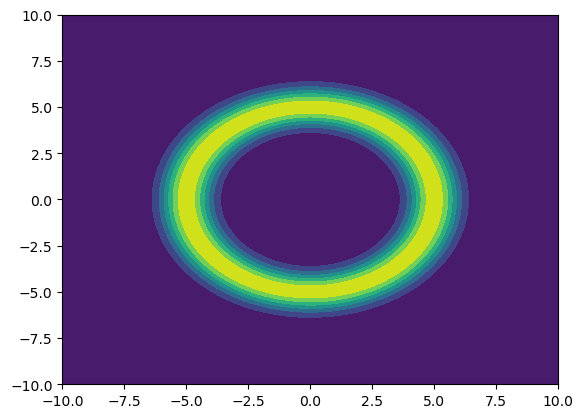

In [5]:
def log_f(params):
    x, y = params
    u = np.sqrt(x*x + y*y)
    return -(u-5)**2

x, y = np.meshgrid(np.linspace(-10, 10, 5000), np.linspace(-10, 10, 5000))
z = np.exp(log_f((x, y)))
plt.contourf(x, y, z)

In [6]:
gp = GaussianProposal(np.diag([1, 1]))
rp = ReflectionProposal()

In [8]:
sampler = Sampler(log_f, 2, [gp, rp], proposal_weights=[1, 1])

In [9]:
sampler.sample((5.0, 0.0), 50000)

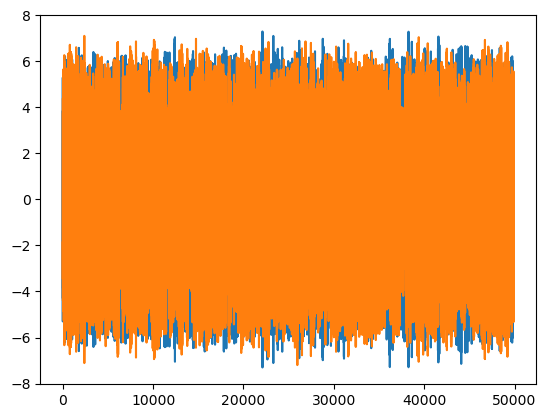

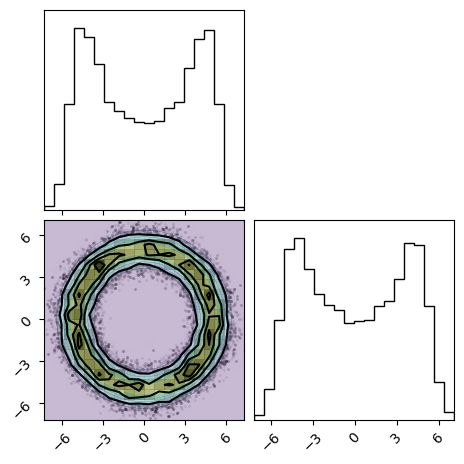

In [10]:
chain = sampler.get_chain(100)

plt.plot(chain[:,0])
plt.plot(chain[:,1])

fig = corner.corner(chain)
plt.subplot(223)
plt.contourf(x, y, z, alpha=0.3)

In [11]:
sampler.acceptance_rate

0.8080838383232335